In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier #,Ridge,Lasso,ElasticNet
from sklearn.metrics import accuracy_score,recall_score,precision_score,roc_auc_score,f1_score,confusion_matrix
#from sklearn.model_selection import train_test_split,cross_val_score,KFold,RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import NearMiss
from sklearn.datasets import make_classification
from sklearn.pipeline import make_pipeline
import numpy as np
import pyreadstat
from collections import Counter


In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import lime
import lime.lime_tabular
import lime.lime_tabular

In [53]:
df = pd.read_csv(r"C:\Users\vishnu\Downloads\loan_fraud.csv")

In [54]:
df.shape

(284807, 31)

In [55]:
X_col = df.drop(columns = 'Class')
y_col = df['Class']

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_col, y_col, test_size=0.20, random_state=42)

In [57]:
def oversample_with_adasyn(X, y, target_minority_samples=180000):
    """
    Oversample the minority class using ADASYN until the minority class reaches the target_minority_samples.
    
    Parameters:
    - X: Feature matrix
    - y: Target vector
    - target_minority_samples: Desired number of samples for the minority class after oversampling
    
    Returns:
    - X_resampled, y_resampled: Feature matrix and target vector after resampling
    """
    # Identify minority class
    classes, counts = np.unique(y, return_counts=True)
    minority_class = classes[np.argmin(counts)]
    current_minority_samples = counts[np.argmin(counts)]

    # Calculate how many new samples we need to generate for the minority class
    if current_minority_samples >= target_minority_samples:
        raise ValueError("The minority class already has more or equal samples than the target_minority_samples.")
    
    n_samples_to_generate = target_minority_samples - current_minority_samples

    # Set the sampling strategy for ADASYN
    # This will tell ADASYN to generate the specified number of samples for the minority class
    sampling_strategy = {minority_class: n_samples_to_generate}

    # Create the ADASYN instance and fit it to the data
    adasyn = ADASYN(sampling_strategy=sampling_strategy, n_neighbors=5, random_state=42)
    X_resampled, y_resampled = adasyn.fit_resample(X, y)

    return X_resampled, y_resampled

In [58]:
def undersample_with_nearmiss(X, y):
    """
    Undersample the majority class using NearMiss until it is balanced with the minority class.
    
    Parameters:
    - X: Feature matrix
    - y: Target vector
    
    Returns:
    - X_resampled, y_resampled: Feature matrix and target vector after resampling
    """
    # Identify majority and minority classes
    classes, counts = np.unique(y, return_counts=True)
    minority_class_count = min(counts)
    
    # Set the sampling strategy for NearMiss
    # This will balance the majority class with the minority class
    nm = NearMiss()
    
    # Perform the undersampling
    X_resampled, y_resampled = nm.fit_resample(X, y)
    
    # Check if undersampling was successful
    if len(np.unique(y_resampled, return_counts=True)[1]) != 2 or np.unique(y_resampled, return_counts=True)[1][0] != minority_class_count:
        raise ValueError("NearMiss did not undersample correctly.")
    
    return X_resampled, y_resampled

In [59]:
X_resampled,y_resampled = oversample_with_adasyn(X_train,y_train)

In [60]:
X_train,y_train = undersample_with_nearmiss(X_resampled,y_resampled)

In [61]:

y_train.value_counts()

Class
0    179696
1    179696
Name: count, dtype: int64

In [62]:
scaler = StandardScaler()

In [63]:

scaler.fit(X_train)

StandardScaler()

In [64]:
X_train_scaled = scaler.transform(X_train)
X_train = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)

In [65]:
X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

logistic regression model building

In [67]:
logr = LogisticRegression(max_iter = 10000)

#Fitting Linear Regression
logr.fit(X_train,y_train)

#Printing errors
print('Accuracy of training is '+ str(accuracy_score(y_train,logr.predict(X_train))))
print('Precision of training is '+ str(precision_score(y_train,logr.predict(X_train))))
print('Recall of training is '+ str(recall_score(y_train,logr.predict(X_train))))
print('F1 of training is '+ str(f1_score(y_train,logr.predict(X_train))))
print('ROC AUC of training is '+ str(roc_auc_score(y_train,logr.predict(X_train))))
print()
print('Accuracy of test is '+ str(accuracy_score(y_test,logr.predict(X_test))))
print('Precision of test is '+ str(precision_score(y_test,logr.predict(X_test))))
print('Recall of test is '+ str(recall_score(y_test,logr.predict(X_test))))
print('F1 of test is '+ str(f1_score(y_test,logr.predict(X_test))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,logr.predict(X_test))))

Accuracy of training is 0.9803306695752827
Precision of training is 0.9914144030789727
Recall of training is 0.9690532900008904
F1 of training is 0.9801063210061377
ROC AUC of training is 0.9803306695752827

Accuracy of test is 0.9755275446789088
Precision of test is 0.061569688768606225
Recall of test is 0.9285714285714286
F1 of test is 0.11548223350253807
ROC AUC of test is 0.9520899489508803


logistic regression with hyperparameter tuning  and randomsearch wirg cv 10

In [69]:
logr = LogisticRegression(solver='lbfgs',max_iter=10000)

#Define grid of hyperparameters
parameter = {'logisticregression__C':[0.01,0.1,1,10],'logisticregression__penalty':['l1','l2']}

pipeline = make_pipeline(StandardScaler(),logr)

random_search = RandomizedSearchCV(estimator=pipeline,param_distributions=parameter,cv=10,scoring='recall',n_jobs=-1,n_iter=10,random_state=42)

#subset = len(X_train) // 10
#Fitting Linear Regression
random_search.fit(X_train,y_train)

check_params = random_search.best_params_
check_model = random_search.best_estimator_

#Predicting the test data
y_train_predict = check_model.predict(X_train)
y_predict = check_model.predict(X_test)


#Printing errors
print('Accuracy of training is '+ str(accuracy_score(y_train,y_train_predict)))
print('Precision of training is '+ str(precision_score(y_train,y_train_predict)))
print('Recall of training is '+ str(recall_score(y_train,y_train_predict)))
print('F1 of training is '+ str(f1_score(y_train,y_train_predict)))
print('ROC AUC of training is '+ str(roc_auc_score(y_train,y_train_predict)))
print()
print('Accuracy of test is '+ str(accuracy_score(y_test,y_predict)))
print('Precision of test is '+ str(precision_score(y_test,y_predict)))
print('Recall of test is '+ str(recall_score(y_test,y_predict)))
print('F1 of test is '+ str(f1_score(y_test,y_predict)))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,y_predict)))

E:\New folder\anaconda\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
E:\New folder\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "E:\New folder\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\New folder\anaconda\Lib\site-packages\sklearn\base.py", line 1151, i

Accuracy of training is 0.9805393553557119
Precision of training is 0.9914404416367879
Recall of training is 0.9694484017451697
F1 of training is 0.9803210975616619
ROC AUC of training is 0.9805393553557119

Accuracy of test is 0.9758435448193532
Precision of test is 0.06232876712328767
Recall of test is 0.9285714285714286
F1 of test is 0.11681643132220795
ROC AUC of test is 0.9522482213200418


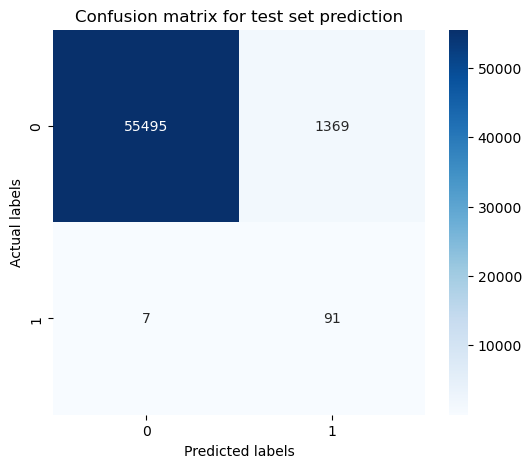

In [71]:
Confusion_matrix_test = confusion_matrix(y_test,y_predict)

#plotting the confusion matrix for the test set prediction
plt.figure(figsize=(6,5))
sns.heatmap(Confusion_matrix_test,annot=True,fmt='g',cmap='Blues',cbar=True)
plt.title('Confusion matrix for test set prediction')
plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')
plt.show()

In [72]:
# Starting XGBoost
logr = XGBClassifier(n_estimators = 1000,learning_rate = 0.01,eval_metric='aucpr')

#Fitting
logr.fit(X_train,y_train)

#Printing errors
print('Accuracy of training is '+ str(accuracy_score(y_train,logr.predict(X_train))))
print('Precision of training is '+ str(precision_score(y_train,logr.predict(X_train))))
print('Recall of training is '+ str(recall_score(y_train,logr.predict(X_train))))
print('F1 of training is '+ str(f1_score(y_train,logr.predict(X_train))))
print('ROC AUC of training is '+ str(roc_auc_score(y_train,logr.predict(X_train))))
print()
print('Accuracy of test is '+ str(accuracy_score(y_test,logr.predict(X_test))))
print('Precision of test is '+ str(precision_score(y_test,logr.predict(X_test))))
print('Recall of test is '+ str(recall_score(y_test,logr.predict(X_test))))
print('F1 of test is '+ str(f1_score(y_test,logr.predict(X_test))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,logr.predict(X_test))))

Accuracy of training is 0.9995687160537797
Precision of training is 0.9992769784372724
Recall of training is 0.9998608761463805
F1 of training is 0.9995688420209348
ROC AUC of training is 0.9995687160537797

Accuracy of test is 0.9974193321863699
Precision of test is 0.3881278538812785
Recall of test is 0.8673469387755102
F1 of test is 0.5362776025236593
ROC AUC of test is 0.9324952195284416


In [73]:
logr = LGBMClassifier(n_estimators = 1000,learning_rate = 0.01)

#Fitting
logr.fit(X_train,y_train)

#Printing errors
print('Accuracy of training is '+ str(accuracy_score(y_train,logr.predict(X_train))))
print('Precision of training is '+ str(precision_score(y_train,logr.predict(X_train))))
print('Recall of training is '+ str(recall_score(y_train,logr.predict(X_train))))
print('F1 of training is '+ str(f1_score(y_train,logr.predict(X_train))))
print('ROC AUC of training is '+ str(roc_auc_score(y_train,logr.predict(X_train))))
print()
print('Accuracy of test is '+ str(accuracy_score(y_test,logr.predict(X_test))))
print('Precision of test is '+ str(precision_score(y_test,logr.predict(X_test))))
print('Recall of test is '+ str(recall_score(y_test,logr.predict(X_test))))
print('F1 of test is '+ str(f1_score(y_test,logr.predict(X_test))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,logr.predict(X_test))))

[LightGBM] [Info] Number of positive: 179696, number of negative: 179696
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 359392, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy of training is 0.9997774018342089
Precision of training is 0.9995827909615834
Recall of training is 0.9999721752292761
F1 of training is 0.9997774451819663
ROC AUC of training is 0.9997774018342088

Accuracy of test is 0.9984199992977775
Precision of test is 0.524390243902439
Recall of test is 0.8775510204081632
F1 of test is 0.6564885496183207
ROC AUC of test is 0.9380896632710484
